In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from qrisp.operators import X, Y, Z
from qrisp.vqe.problems.heisenberg import *
import networkx as nx

import pickle
from time import time
from datetime import datetime

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

In [2]:
L = 10
G = nx.Graph()
G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 

J = 1
B = 0.5
H = create_heisenberg_hamiltonian(G, J, B)

H_matrix = H.to_array()
eigvals, eigvecs = np.linalg.eigh(H_matrix)
idx = np.argsort(eigvals)
eigvals_sorted = eigvals[idx].real
print('Eigen energies:', eigvals_sorted)
eigvecs_sorted = eigvecs[:,idx].T
eigvecs_sorted = [vec.reshape(-1,1) for vec in eigvecs_sorted]


Eigen energies: [-17.03214083 -16.72269436 -15.72269436 ...  12.80422607  13.
  14.        ]


In [3]:
results = load_data('data/benchmarks_manual_2nd_B=0.5_03-20-20')

# QITE with manually setup eigenstates

In [4]:
indices = [0,2,4] # GC
#indices = [1,3,4] # HOPF

mid_id_ls = [1,2,4]
beta_lists = {1:results[indices[0]]["evolution_times"],2:results[indices[1]]["evolution_times"],4:results[indices[2]]["evolution_times"]}
energy_dict = {1:results[indices[0]]["optimal_energies"],2:results[indices[1]]["optimal_energies"],4:results[indices[2]]["optimal_energies"]}
fluctuation_dict = {1:results[indices[0]]["variances"],2:results[indices[1]]["variances"],4:results[indices[2]]["variances"]}

fidelity_dict = {}

beta_max = np.max([np.max(beta_lists[i]) for i in mid_id_ls])

psi = eigvecs_sorted[0]

states = results[0]["statevectors"]
energies = results[0]["optimal_energies"]

for i in range(3):
    fidelities = []

    psi = eigvecs_sorted[mid_id_ls[i]]
    states = results[indices[i]]["statevectors"]

    for phi in states:
        fidelities.append(np.abs(np.dot(psi.transpose()[0],phi))**2)
    fidelity_dict[mid_id_ls[i]] = fidelities



In [5]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

run_param_rc(18)

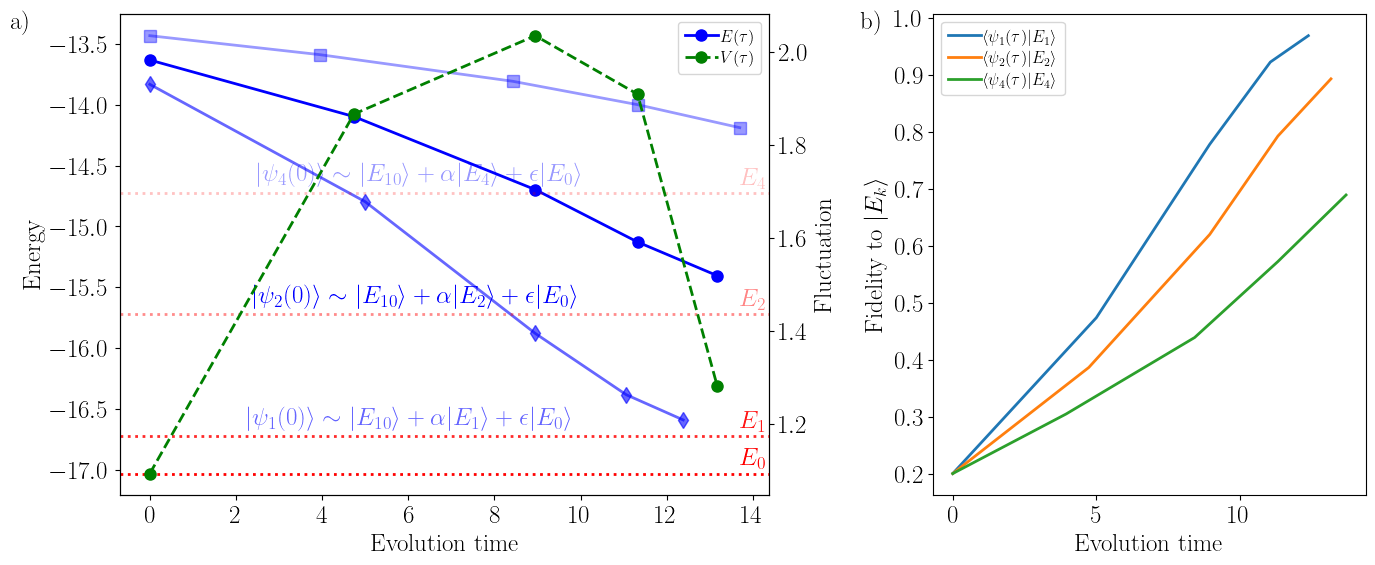

In [6]:
# Create a figure with 2 subplots side-by-side
fig, (ax_energy, ax_fidelity) = plt.subplots(1, 2, 
                                             figsize=(14, 6),
                                             gridspec_kw={"width_ratios":[1.5,1]})
a = -.17
b = .97
ax_energy.annotate('a)', xy = (a,b), xycoords='axes fraction')
ax_fidelity.annotate('b)', xy = (a,b), xycoords='axes fraction')

###############################################################################
# SUBPLOT 1: Energy + fluctuation (with a twin y-axis)
###############################################################################
ax1 = ax_energy  # rename for clarity

# Plot a horizontal line for the ground-state energy
#ax1.axline((beta_list[0], eigvals_sorted[0]), 
#           (beta_list[-1], eigvals_sorted[0]), 
#           linestyle=":", color="red")
ax1.axhline(y=eigvals_sorted[0], color="red", linestyle=':')

ax1.text(
    beta_max,           # shift text slightly to the right
    eigvals_sorted[0]+0.12,             # same y as the line
    r"$E_0$",                           # label for that line
    va="center",
    ha="left",
    color="red",
)

alphas = [0.6, 1, 0.4]
markers = ['d','o','s']

# Plot energies for each mid_id
for i, mid_id in enumerate(mid_id_ls):
    # Possibly highlight mid_id=2 with a label
    if mid_id == 2:
        line1, = ax1.plot(
            beta_lists[mid_id], 
            energy_dict[mid_id], 
            # label=rf"$\langle \psi^{{{mid_id}}}(\tau)|\hat H|\psi_{{{mid_id}}}(\tau)\rangle$", 
            label=rf"$E(\tau)$",
            color="blue", 
            marker = markers[i],
            alpha=alphas[i]
        )
    else:
        line1, = ax1.plot(
            beta_lists[mid_id], 
            energy_dict[mid_id], 
            color="blue", 
            marker = markers[i],
            alpha=alphas[i]
        )

    # Annotations on each line (example)
    ax1.text(
        beta_lists[mid_id][-1]/6 + 0.2, 
        eigvals_sorted[mid_id]+0.15,
        rf"$|\psi_{{{mid_id}}}(0)\rangle \sim |E_{{10}}\rangle + \alpha |E_{{{mid_id}}}\rangle + \epsilon |E_0\rangle$",
        va="center",
        ha="left",
        color="blue",
        alpha=alphas[i]
    )

    # Horizontal line for the mid_id'th eigenvalue
    #ax1.axline(
    #    (beta_list[0], eigvals_sorted[mid_id]),
    #    (beta_list[-1], eigvals_sorted[mid_id]),
    #    linestyle=":",
    #    color="red",
    #    alpha=1.0 / (int(mid_id) + 0.2)
    #)
    ax1.axhline(y=eigvals_sorted[mid_id], color="red", linestyle=':', alpha=1.0 / (int(mid_id) + 0.2))

    ax1.text(
        beta_max,
        eigvals_sorted[mid_id] + 0.12,
        f"$E_{mid_id}$",
        va="center",
        ha="left",
        color="red",
        alpha=1.0 / (int(mid_id) + 0.1)
    )

ax1.set_xlabel("Evolution time")
ax1.set_ylabel("Energy")

# Create a twin axis for fluctuation
ax2 = ax1.twinx()
for i, mid_id in enumerate(mid_id_ls):
    if mid_id==2:
        line2, = ax2.plot(
            beta_lists[mid_id], 
            fluctuation_dict[mid_id],
            # label=r"$\langle \psi_2(\tau)|(\hat H-E(\tau))^2|\psi_2(\tau)\rangle$",
            label=r"$V(\tau)$",
            color="green",
            linestyle='dashed',
            marker=markers[i]
        )
ax2.set_ylabel("Fluctuation")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

###############################################################################
# SUBPLOT 2: Fidelity to the ground state
###############################################################################
axF = ax_fidelity

# Plot fidelity for each mid_id (example)
for i, mid_id in enumerate(mid_id_ls):
    lineF, = axF.plot(
        beta_lists[mid_id], fidelity_dict[mid_id],
        label=rf"$\langle\psi_{{{mid_id}}}(\tau)|E_{{{mid_id}}}\rangle$",
    )

axF.set_xlabel("Evolution time")
axF.set_ylabel(r"Fidelity to $|E_k\rangle$")

axF.legend(loc="best")

plt.tight_layout()
plt.savefig("plots/QITE_manual_rescaled__2nd_B=0.5.pdf")
plt.show()